<a href="https://colab.research.google.com/github/davidislip/SVM-and-MVO/blob/main/ADM_Factor_OOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integration of SVM and MVO 

This notebook performs a comparison of the integrated MVO-SVM min variance portfolios obtained via the exact MIP solve vs the ADM method


In [ ]:
!sudo python -m pip install gurobipy==9.1.2
import gurobipy as gp
from gurobipy import GRB
from google.colab import drive 
import math
import time
drive.mount('/content/gdrive')
pth = 'gdrive/My Drive/Colab Notebooks/'
import sys
sys.path.append(pth + 'SVM MVO/PYFILES/')
from packages import *
#from svm_mvo import *
%matplotlib inline

## Import Forecasts
forecasts = pd.read_pickle(pth +'SVM MVO/DATA/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'SVM MVO/DATA/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_ASOF.pkl')
wrds_svm_pca = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_PCA.pkl')
#wrds_svm_pca['Momentum'] = wrds_svm.Momentum
## Import Monthly Prices
prices = pd.read_pickle(pth + 'SVM MVO/DATA/PRICES.pkl')

     |████████████████████████████████| 11.1 MB 11.6 MB/s 
Mounted at /content/gdrive


In [ ]:
try:
  e = gp.Env(empty=True)
  #e.setParam('OutputFlag', 0)
  gurobi_licence = pd.read_csv(pth +'SVM MVO/DATA/gurobi.csv')
  e.setParam('WLSACCESSID', gurobi_licence.WLSACCESSID[0])
  e.setParam('LICENSEID', gurobi_licence.LICENSEID[0])
  e.setParam('WLSSECRET', gurobi_licence.WLSSECRET[0])
  e.start()
except: 
  !chmod 755 /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey
  !/content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey 2d15bcec-464e-11ec-8a74-0242ac120003
  e = gp.Env(empty=True)
  #chmod 755 grbgetkey
  e.start()

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET
info  : grbgetkey version 9.1.2, build v9.1.1rc0-30-g8af970cb
info  : Contacting Gurobi license server...
info  : License file for license ID 726787 was successfully retrieved
info  : License expires at the end of the day on 2022-01-13
info  : Saving license file...

In which directory would you like to store the Gurobi license file?
[hit Enter to store it in /opt/gurobi]: 

info  : License 726787 written to file /opt/gurobi/gurobi.lic
Academic license - for non-commercial use only - expires 2022-01-13
Using license file /opt/gurobi/gurobi.lic


In [ ]:
%run /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/PYFILES/svm_mvo.py

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET
Academic license - for non-commercial use only - expires 2022-01-13
Using license file /opt/gurobi/gurobi.lic


## Part 1

In [ ]:
wrds_svm.columns[40:]

Index(['niy', 'oancfy', 'txty', 'dvpspq', 'mkvaltq', 'prccq', 'date',
       'DIFFYear', 'DIFFMonth', 'DIFFActualDays', 'DIFFExpectedDays',
       'DIFFExpectedDaysCorr', 'DIFFdatadate', 'DIFFsrcq', 'DIFFactq',
       'DIFFancq', 'DIFFatq', 'DIFFceqq', 'DIFFcheq', 'DIFFcogsq', 'DIFFcshiq',
       'DIFFcshopq', 'DIFFcshoq', 'DIFFcstkq', 'DIFFdlcq', 'DIFFdlttq',
       'DIFFdpq', 'DIFFepspi12', 'DIFFepspiq', 'DIFFepspxq', 'DIFFintanq',
       'DIFFinvtq', 'DIFFlctq', 'DIFFlltq', 'DIFFltq', 'DIFFniq', 'DIFFoibdpq',
       'DIFFopepsq', 'DIFFrectq', 'DIFFreq', 'DIFFsaleq', 'DIFFteqq',
       'DIFFcapxy', 'DIFFdltisy', 'DIFFdltry', 'DIFFniy', 'DIFFoancfy',
       'DIFFtxty', 'DIFFdvpspq', 'DIFFmkvaltq', 'DIFFprccq', 'ROC1', 'ROC2',
       'ROC3', 'ROC4', 'ROC5', 'INV1', 'INV2', 'INV3', 'PRO1', 'PRO2', 'PRO3',
       'PRO4', 'PRO5', 'PRO6', 'PRO7', 'LEV1', 'LEV2', 'LEV3', 'LEV4', 'LEV5',
       'RET1', 'LIQ1', 'LIQ2', 'LIQ3', 'LIQ4', 'LIQ5', 'RISK1', 'RISK2',
       'RISK3', 'GRW1', 'GRW2', 

In [ ]:
mth = rets.index[0]
mth

Timestamp('2000-07-01 00:00:00')

In [ ]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))

#preprocessing 
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N] 
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)

#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
Y = wrds_tics.loc[:,['GRW1', 'LEV1', 'Momentum']] # Y matrix in formulation 
# Y['Momentum'] = wrds_tics.Momentum
#restrict the wharton research data to the columns of interest
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0)) #scale the features 
cols = Y_.columns.tolist() #use all the columns for this formulation
AssetLim = math.floor(N*0.9)
ret_constr = -1
soft_margin = 2500
dpi_setting = 150
Y_.head()
#['INV1', 'INV3', 'PRO5', 'LIQ2', 'LIQ4', 'LIQ5'] bad results
# ['INV3' ,  'LIQ5' ,  'GRW5'  ,  'LEV5' ,  'GRW7' ,  'Momentum' ] correlation hacking 

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

,GRW1,LEV1,Momentum
tic,,,
AAPL,0.381863,-0.234034,0.001715
ABC,-0.380565,-0.027453,2.659668
ABMD,0.453107,-0.279032,-0.903663
ABT,0.323947,-0.147613,0.593619
ADBE,0.762118,-0.279032,1.627597


In [ ]:
# test = pd.merge(left = wrds_svm, right = rets, left_on = 'MonthStart', right_index = True)
# test
wrds_svm_lng =wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].reset_index()
rets_lng = rets.melt(ignore_index = False,
        var_name="tic", 
        value_name="Return").reset_index()
rets_lng

test = pd.merge(wrds_svm_lng, rets_lng, left_on = ['MonthStart', 'tic'], right_on = ['StartMonth', 'tic'])
corrs = test.loc[:,'ROC1':].corr()
corrs.iloc[-1].sort_values()

GRW4       -0.037563
ROC1       -0.025747
RISK1      -0.020220
RISK2      -0.020146
GRW3       -0.011779
PRO1       -0.009867
PRO2       -0.009828
Vol        -0.009808
PRO7       -0.009430
INV2       -0.006706
GRW6       -0.006495
PRO4       -0.003385
RISK3      -0.002927
INV1       -0.002237
ROC4       -0.002082
LEV2       -0.001774
ROC5       -0.001721
ROC3       -0.001718
GRW2       -0.001526
ROC2       -0.001041
GRW1       -0.000930
LEV1       -0.000430
PRO6       -0.000260
LIQ4       -0.000080
LEV4        0.000553
LEV3        0.000796
PRO3        0.001157
PRO5        0.002005
GRW8        0.002261
LIQ3        0.002659
LIQ2        0.005731
LIQ1        0.011179
LIQ5        0.012445
RET1        0.015775
GRW5        0.017683
INV3        0.020703
LEV5        0.031580
GRW7        0.042796
Momentum    0.627046
Return      1.000000
Name: Return, dtype: float64

In [ ]:
MVO_ = MVO(tics, mean, cov, ret_constr, Y_, AssetLim)
SVM_ = SVM(tics, Y_ , soft_margin)
SVM_MVO_Fast = SVM_MVO_ADM(MVO_, SVM_, IterLim = 10)
SVM_MVO_Fast.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast.SVM_.model.params.OutputFlag = 0
SVM_MVO_Fast.MVO_.model.params.TimeLimit = 60
SVM_MVO_Fast.SVM_.model.params.TimeLimit = 60

SVM_MVO_Fast.silence_output()

SVM_MVO_Fast.initialize_soln()

ws , xs, zs , xi_mvo, xi_svm, dt = SVM_MVO_Fast.solve_ADM()
print("Solution time", dt)


Solution time 7.149301290512085


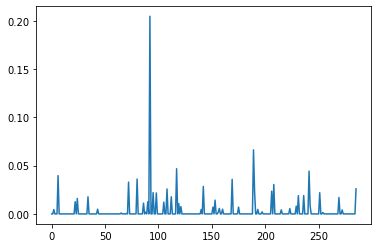

In [ ]:
plt.plot(SVM_MVO_Fast.x.x)

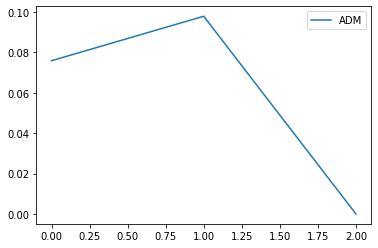

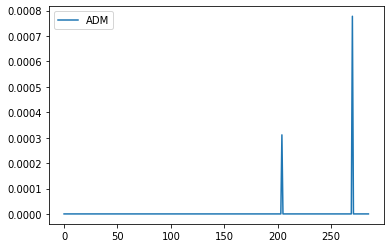

In [ ]:
# plt.plot(SVM_MVO_Slck.w.x, label = 'Slack')
plt.plot(SVM_MVO_Fast.w.x, label= 'ADM')
plt.legend();

plt.figure()
#plt.plot(SVM_MVO_Slck.xi.x, label = 'Slack')
plt.plot(SVM_MVO_Fast.xi_mvo.x, label= 'ADM')
plt.legend();

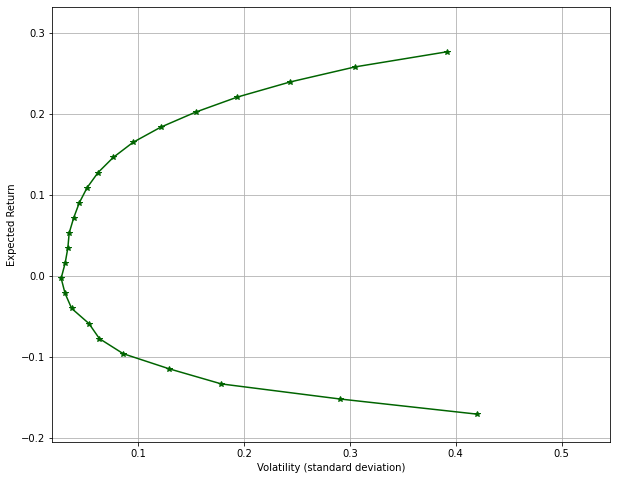

In [ ]:
adm_ef = SVM_MVO_Fast.get_frontier();

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 2 rows, 572 columns and 572 nonzeros
Model fingerprint: 0xdc0310da
Model has 41041 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 286 columns
Presolve time: 0.02s
Presolved: 2 rows, 286 columns, 572 nonzeros
Presolved model has 41041 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 285
 AA' NZ     : 4.104e+04
 Factor NZ  : 4.133e+04 (roughly 1 MByte of memory)
 Factor Ops : 7.921e+06 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.21402282e+05 -2.21402282e+05  1.16e+0

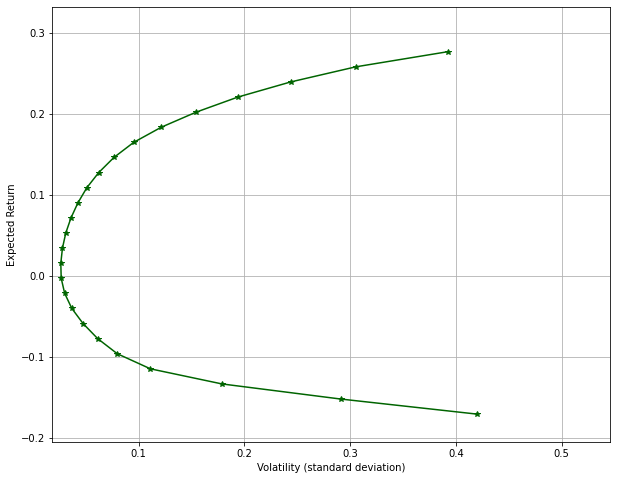

In [ ]:
MVO2 = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim,\
             svm_choice = (False, False), print_var_frntr= False) #define an instance of the class
MVO2.setModel() #set up the model
MVO2.optimize() #find optimal solution
MVO2.model.params.outputflag = 0
mv_ef = MVO2.get_frontier()

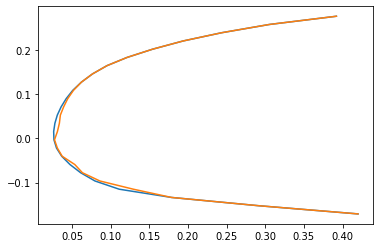

In [ ]:
plt.plot(mv_ef[0][0], mv_ef[0][1]);
plt.plot(adm_ef[0][0], adm_ef[0][1]);

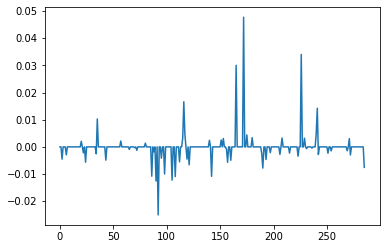

In [ ]:
plt.plot(MVO2.x.x - SVM_MVO_Fast.x.x)
prev_mvo = MVO2.x.X
prev_svm = SVM_MVO_Fast.x.x

In [ ]:
return_premium = 0.1 #similiar to Costa and Kwon 
#Limit = 0.75/6 #1/6 because Costa and Kwon use 1 for 6 month period. 
T = len(rets.index)

def evaluate_adm(rets, forecasts, wrds_svm, return_premium, model_instance, \
                 T, N, cols, TurnoverLimit):
  lr = 0.1 #learning rate for the SVM support vector
  portfolio_weights = np.zeros([T,N])
  oot_returns = np.zeros(T)
  market = np.zeros(T)
  M = len(cols)
  wis = np.zeros([T,M])
  bias = np.zeros(T)
  times = []
  i = 0 #index for dates
  w_mabs = 10**(-9) #initialize
  soln_mods = {}

  for prd in rets.index.to_list()[:T]:
    ret_ = rets.loc[prd][:N]
    cov_, mean_ = forecasts[prd]
    cov = cov_[:N,:N]
    mean = mean_[:N,:]
    tics = list(rets.columns[:N])
    return_premium_temp = return_premium 
    #get the wharton research data for the valid tickers for the month
    wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(prd, level="MonthStart")
    #restrict the wharton research data to the columns of interest
    #modifying WRDS dataset here if required
    Y = wrds_tics.loc[:,cols] # Y matrix in formulation 
    Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
    if return_premium == -1:
      ret_constr = -1
    else:
      ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium)
    model_instance.MVO_.tics = tics
    model_instance.SVM_.tics = tics
    model_instance.MVO_.ret_constr = ret_constr
    model_instance.MVO_.mean_ret = mean
    model_instance.MVO_.cov = cov
    model_instance.MVO_.exogenous = Y_
    model_instance.SVM_.exogenous = Y_
    mvo_cons = []
    svm_cons = []

    if i > 0: #not the first trade gets a constraint on turnover
    #turnover constraint
      x_prev = model_instance.MVO_.x.X
    #policy constraint
      w_mabs = (i/(i+1))*w_mabs + (1/(i+1))*np.abs(model_instance.SVM_.w.x).mean()
      
      w_prev = model_instance.SVM_.w.x
      b_prev = model_instance.SVM_.b.x
    #add turnover constraints
      for v, absv, curr in zip(model_instance.MVO_.x.tolist(), model_instance.MVO_.abs.tolist(), x_prev.tolist()):
        mvo_cons.append(absv >= v - curr)
        mvo_cons.append(absv >= curr - v)
      #q = cost*1/np.maximum(1, Prices)
      q = 1*1/np.maximum(1, np.ones_like(x_prev))
      mvo_cons.append(model_instance.MVO_.abs @ q <= TurnoverLimit)
    #add constraints on w
      u = model_instance.SVM_.model.addMVar(M, lb = np.zeros(M), ub = np.ones(M))
      #epsilon allows change if w is 0
      svm_cons.append(model_instance.SVM_.w <= w_prev + lr*w_mabs*u + model_instance.epsilon)# 'iter constraint 1'
      svm_cons.append(model_instance.SVM_.w >= w_prev - lr*w_mabs*u - model_instance.epsilon)  #'iter constraint 2'

    model_instance.initialize_soln(constrs = mvo_cons, svm_constrs = svm_cons)
    k = 1
    while model_instance.MVO_.model.status == 4:
      #if the model is infeasible the decrease the return constraint
      #we do not have enough turnover the modify the portfolio to achive the 
      #return target... not a great place to be
      print("Infeasible return constraint...Relaxing")
      return_premium_temp = return_premium - 0.05*k
      ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium_temp)
      model_instance.MVO_.ret_constr = ret_constr
      model_instance.MVO_.ret_target[0].rhs = ret_constr
      model_instance.initialize_soln(constrs = mvo_cons, svm_constrs = svm_cons)
      k = k+1


    #model_instance.silence_output()
    model_instance.solve_ADM(store_data=False, constrs = mvo_cons, svm_constrs = svm_cons)
    
    k = 1
    while model_instance.MVO_.model.status == 4:
      #if the model is infeasible the decrease the return constraint
      #we do not have enough turnover the modify the portfolio to achive the 
      #return target... not a great place to be
      print("Infeasible return constraint...Relaxing")
      return_premium_temp = return_premium - 0.05*k
      ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium_temp)
      model_instance.MVO_.ret_constr = ret_constr
      model_instance.MVO_.ret_target[0].rhs = ret_constr
      model_instance.solve_ADM(store_data=False, constrs = mvo_cons, svm_constrs = svm_cons)
      k = k+1
    


    # if model_instance.model.IsMIP:
    #   soln_mods[prd] = [model_instance.model.MIPGap, return_premium_temp]
    # else:
    model_instance.w = model_instance.w.x #convert to numpy array
    model_instance.b = model_instance.b.x
    # alpha = 0.95
    # if i > 0:
    #   model_instance.MVO_.svm_w = alpha*(model_instance.SVM_.w.x) + (1- alpha)*(w_prev)
    #   model_instance.MVO_.svm_b = alpha*(model_instance.SVM_.b.x) + (1- alpha)*(b_prev)
    #   model_instance.MVO_.optimize()
    #   model_instance.x =  model_instance.MVO_.x
    #   model_instance.w =  model_instance.MVO_.svm_w #numpy
    #   model_instance.b =  model_instance.MVO_.svm_b #numpy

    soln_mods[prd] = return_premium_temp
    oot_returns[i] = model_instance.evaluate(ret_)
    market[i] = ret_.mean()
    portfolio_weights[i, :] = model_instance.x.x
    times.append(dt)
    wis[i,:] = model_instance.w
    bias[i] = model_instance.b

    if i + 1 >= T:
      break
      
    if i%12 == 0:
      print("_"*25)
      print("Iteration ", i)
      print("Percent Complete ", i/T)
    i = i+1
  
  portfolio_weights = pd.DataFrame(portfolio_weights, index = rets.index[:T], columns = model_instance.tics)
  oot_returns = pd.Series(oot_returns, index = rets.index[:T])
  market = pd.Series(market, index = rets.index[:T])
  return (portfolio_weights, oot_returns, market, wis, bias, soln_mods, times)

In [ ]:
adm_results = evaluate_adm(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Fast, T, N, cols, 0.75/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/oot_3_0_75.pkl", 'wb') as fp:
  pkl.dump(adm_results, fp);

adm_results = evaluate_adm(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Fast, T, N, cols, 1/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/oot_3_1.pkl", 'wb') as fp:
  pkl.dump(adm_results, fp);

adm_results = evaluate_adm(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Fast, T, N, cols, 1.25/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/oot_3_1_25.pkl", 'wb') as fp:
  pkl.dump(adm_results, fp);



_________________________
Iteration  0
Percent Complete  0.0
_________________________
Iteration  12
Percent Complete  0.04918032786885246
_________________________
Iteration  24
Percent Complete  0.09836065573770492
Infeasible return constraint...Relaxing
Infeasible return constraint...Relaxing
Infeasible return constraint...Relaxing
_________________________
Iteration  36
Percent Complete  0.14754098360655737
_________________________
Iteration  48
Percent Complete  0.19672131147540983
_________________________
Iteration  60
Percent Complete  0.2459016393442623
_________________________
Iteration  72
Percent Complete  0.29508196721311475
_________________________
Iteration  84
Percent Complete  0.3442622950819672
_________________________
Iteration  96
Percent Complete  0.39344262295081966
Infeasible return constraint...Relaxing
Infeasible return constraint...Relaxing
Infeasible return constraint...Relaxing
Infeasible return constraint...Relaxing
Infeasible return constraint...Relaxi

## Part 2 : Standard MVO Results 

In [ ]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))

#preprocessing 
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)

#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")

#restrict the wharton research data to the columns of interest
Y = wrds_tics.loc[:,"ROC1":"Vol"] # Y matrix in formulation as per the paper
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0)) #scale the features 
cols = ['GRW1', 'LEV1', 'Momentum'] #Use Growth, Leverage and Momentum as factors
                                    #for the SVM
Y_ = Y_[cols]

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

In [ ]:
#SVM with slack 
SVM_MVO_Slck = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim, \
                      svm_choice = (True, True), print_var_frntr = True )
SVM_MVO_Slck.setModel()
SVM_MVO_Slck.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 1147 rows, 1148 columns and 5434 nonzeros
Model fingerprint: 0x088b7516
Model has 41044 quadratic objective terms
Variable types: 862 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+05]
  Objective range  [9e+00, 9e+00]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 3e+02]
Found heuristic solution: objective 5.000000e+12
Presolve removed 1 rows and 286 columns
Presolve time: 0.01s
Presolved: 1146 rows, 862 columns, 5148 nonzeros
Presolved model has 41044 quadratic objective terms
Variable types: 576 continuous, 286 integer (286 binary)

Root relaxation: objective 6.861009e-04, 664 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective

123.14473700523376

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 2 rows, 572 columns and 572 nonzeros
Model fingerprint: 0xdc0310da
Model has 41041 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 286 columns
Presolve time: 0.03s
Presolved: 2 rows, 286 columns, 572 nonzeros
Presolved model has 41041 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 285
 AA' NZ     : 4.104e+04
 Factor NZ  : 4.133e+04 (roughly 1 MByte of memory)
 Factor Ops : 7.921e+06 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Du

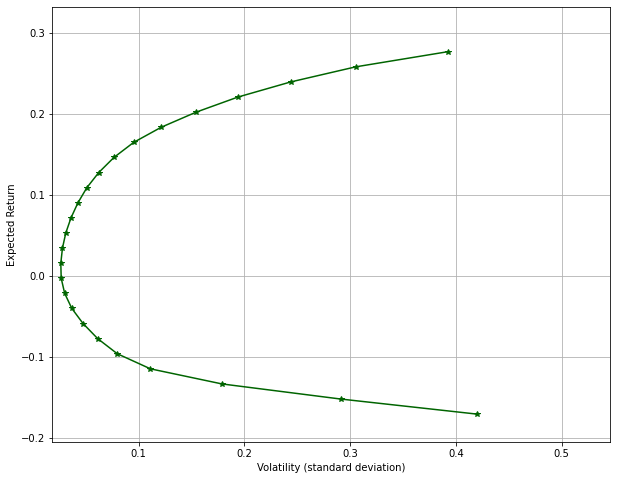

In [ ]:
MVO2 = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim,\
             svm_choice = (False, False), print_var_frntr= False) #define an instance of the class
MVO2.setModel() #set up the model
MVO2.optimize() #find optimal solution
MVO2.model.params.outputflag = 0
mv_ef = MVO2.get_frontier()

In [ ]:

def evaluate_model(rets, forecasts, wrds_svm, return_premium, model_instance, T, N, cols, Limit):
  lr = 0.1 #learning rate for the SVM support vector
  weights = np.zeros([T,N])
  oot_returns = np.zeros(T)
  market = np.zeros(T)
  M = len(cols)
  wis = np.zeros([T,M])
  bias = []
  i = 0 #index for dates
  w_mabs = 0 #initialize
  soln_mods = {}
  for prd in rets.index.to_list()[:T]:
    ret_ = rets.loc[prd][:N]
    cov_, mean_ = forecasts[prd]
    cov = cov_[:N,:N]
    mean = mean_[:N,:]
    tics = list(rets.columns[:N])
    return_premium_temp = return_premium 
    #get the wharton research data for the valid tickers for the month
    wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(prd, level="MonthStart")
    #restrict the wharton research data to the columns of interest
    #modifying WRDS dataset here if required
    Y = wrds_tics.loc[:,cols] # Y matrix in formulation 
    Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
    ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium)
    model_instance.tics = tics
    model_instance.ret_constr = ret_constr
    model_instance.mean_ret = mean
    model_instance.cov = cov
    model_instance.exogenous = Y_
    if i > 0: #not the first trade gets a constraint on turnover
      x_prev = model_instance.x.X

      if model_instance.svm_constr:
        w_mabs = (i/(i+1))*w_mabs + (1/(i+1))*np.abs(model_instance.w.x).mean()
        w_prev = model_instance.w.x

    model_instance.setModel()

    if i > 0: #not the first trade gets a constraint on turnover
      model_instance.define_turnover(x_prev, np.ones_like(x_prev), Limit, 1)

      if model_instance.svm_constr:
        u = model_instance.model.addMVar(M, lb = np.zeros(M), ub = np.ones(M))
        wcon1 = model_instance.model.addConstr(model_instance.w <= w_prev + lr*w_mabs*u + model_instance.epsilon, 'iter constraint 1')
        wcon2 = model_instance.model.addConstr(model_instance.w >= w_prev - lr*w_mabs*u - model_instance.epsilon, 'iter constraint 2')

    model_instance.model.Params.LogToConsole = 0
    
    model_instance.optimize(cbb = cb)
    k = 1
    while model_instance.model.status == 4:
      #if the model is infeasible the decrease the return constraint
      #we do not have enough turnover the modify the portfolio to achive the 
      #return target... not a great place to be
      return_premium_temp = return_premium - 0.05*k
      ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium_temp)
      model_instance.ret_constr = ret_constr
      model_instance.ret_target[0].rhs = ret_constr
      model_instance.optimize(cbb = cb)
      k = k+1
      #relax the return target bc the turnover constraint isnt allowing it to solve
    oot_returns[i] = model_instance.evaluate(ret_)
    market[i] = ret_.mean()
    weights[i, :] = model_instance.x.x
    if model_instance.model.IsMIP:
      soln_mods[prd] = [model_instance.model.MIPGap, return_premium_temp]
    else:
      soln_mods[prd] = return_premium_temp
    if model_instance.svm_constr:
      wis[i,:] = model_instance.w.x
      bias.append(model_instance.b.x)
      # if model_instance.w.x >= w_prev + lr*w_mabs  and wcon2.Pi < 10**(-7):
      #   lr = lr/2
    if i + 1 >= T:
      break
    if i%12 == 0:
      print("_"*25)
      print("Iteration ", i)
      print("Percent Complete ", i/T)
    i = i+1
  
  weights = pd.DataFrame(weights, index = rets.index[:T], columns = model_instance.tics)
  oot_returns = pd.Series(oot_returns, index = rets.index[:T])
  market = pd.Series(market, index = rets.index[:T])
  return (weights, oot_returns, market, wis, bias, soln_mods)


In [ ]:
import time
def cb(model, where):
    if where == GRB.Callback.MIPNODE:
        # Get model objective
        obj = model.cbGet(GRB.Callback.MIPNODE_OBJBST)

        # Has objective changed?
        if abs(obj - model._cur_obj) > 1e-8:
            # If so, update incumbent and time
            model._cur_obj = obj
            model._time = time.time()

    # Terminate if objective has not improved in 60s
    if time.time() - model._time > 120:
        model.terminate()
mvo_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, MVO2, T, N, cols, 0.75/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/mvo__oot_results__turnover0_75by6.pkl", 'wb') as fp:
  pkl.dump(mvo_results, fp);

mvo_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, MVO2, T, N, cols, 1/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/mvo__oot_results__turnover1by6.pkl", 'wb') as fp:
  pkl.dump(mvo_results, fp);

# svm_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Slck, T, N, cols, 0.75/6)
# with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/svm_oot_results_turnover0_75by6.pkl", 'wb') as fp:
#   pkl.dump(svm_results, fp);

Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
_________________________
Iteration  0
Percent Complete  0.0
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-co

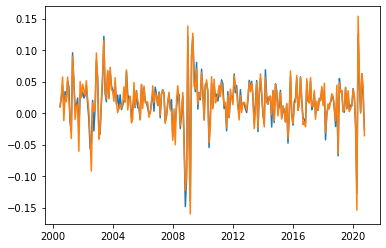

In [ ]:
plt.plot(mvo_results[1])
plt.plot(adm_results[1])

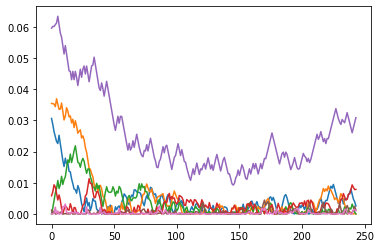

In [ ]:
plt.plot(adm_results[3])

In [ ]:
pd.DataFrame(adm_results[3], index = rets.index)

,0,1,2,3,4,5,6
StartMonth,,,,,,,
2000-07-01,0.030628,3.544761e-02,1.729446e-12,0.005829,0.059620,1.185018e-03,2.038611e-11
2000-08-01,0.028680,3.538524e-02,1.947923e-03,0.007075,0.060173,4.673593e-14,7.166962e-05
2000-09-01,0.026413,3.525067e-02,4.214791e-03,0.009342,0.060123,9.471202e-04,2.531363e-04
2000-10-01,0.024878,3.440343e-02,6.652599e-03,0.008615,0.060734,8.059079e-15,2.162338e-03
2000-11-01,0.023219,3.694638e-02,8.125770e-03,0.006549,0.061235,4.411784e-15,7.785761e-15
...,...,...,...,...,...,...,...
2020-06-01,0.007971,2.957813e-04,1.543261e-03,0.007709,0.027654,4.779893e-15,9.992034e-15
2020-07-01,0.006361,6.172226e-05,3.153547e-03,0.009320,0.026043,5.864736e-04,4.140648e-05
2020-08-01,0.004750,6.121692e-14,2.100531e-03,0.008497,0.027654,1.129386e-03,1.410368e-03
